In [ ]:
#notebook for plotting bias in SST WSPD and WSC and Z20

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os
 

In [2]:
datadir = '/home/z5113258/Documents/data/CMIP6_HB_new/'
#dict with file names
varis = {'Wspd':'_wspd.nc', 'WSC':'_wsc.nc', 'SST':'_tos.nc'}
models={}
#get all data for temp tendency
for model in os.listdir(datadir):
    #go thorugh all varis
    if model in ['NESM3']:
        pass
    else:
        mod={}
        for key in varis.keys():
            #input file
            inp_files = (os.path.join(datadir, model, str(model+varis[key])))
            try:
                #load in file
                var = xr.open_dataarray(inp_files)
                #put into dict
                mod[key]=var
            except Exception as e:
                print(e)
                pass
        #now append data to model dict
        models[model] = mod


[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_wspd.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_wsc.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_tos.nc'


In [3]:
def get_model_TS(MM_D):
    for i, model in enumerate(MM_D.keys()):
        try:
            HB = MM_D[model]
            SST=HB['SST']
            WSP=HB['Wspd']
            WSC=HB['WSC']

            #now turn all these variables into an array
            if i == 0:
                SSTM = SST
                WSPM = WSP
                WSCM = WSC

            else:
                SSTM = xr.concat([SSTM, SST], dim = 'model')
                WSPM = xr.concat([WSPM, WSP], dim = 'model')
                WSCM = xr.concat([WSCM, WSC], dim = 'model')
        except:
            print('error', model)
    return SSTM, WSPM, WSCM

In [4]:
for i, model in enumerate(models.keys()):
    try:    
        HB = models[model]
        SST=HB['SST']
        #SST = SST.assign_coords({"model":i})
        WSP=HB['Wspd']
        WSC=HB['WSC']
        
        #now turn all these variables into an array
        if i == 0:
            SSTM = SST
            WSPM = WSP
            WSCM = WSC
            
        else:
            SSTM = xr.concat([SSTM, SST], dim = 'model')
            WSPM = xr.concat([WSPM, WSP], dim = 'model')
            WSCM = xr.concat([WSCM, WSC], dim = 'model')
    except:
            print('error')

error


In [5]:
SSTMM = SSTM.median('model')
WSPMM = WSPM.median('model')
WSCMM = WSCM.median('model')

In [6]:
def WSC(tx, ty):
    dtydx = ty.differentiate('lon') / (110e3 * np.cos(ty.lat * np.pi / 180))
    dtxdy = tx.differentiate('lat') / (110e3 )
    wsc = dtydx-dtxdy
    wsc = wsc.groupby('time.month').mean('time')
    return wsc

In [7]:
import xarray.ufuncs as xu
def wspd(tx, ty):
    ws = xu.sqrt(tx**2+ty**2)
    ws = ws.groupby('time.month').mean('time')
    return ws


In [8]:
#load in obs data
UO = xr.open_mfdataset('/home/z5113258/Documents/data/NCEPII_uwnd.nc', parallel=True).uwnd
VO = xr.open_mfdataset('/home/z5113258/Documents/data/NCEPII_vwnd.nc', parallel=True).vwnd


In [8]:
g_tu = xr.open_mfdataset('/home/z5113258/Documents/GODAS/remapcon_1/uflx/*.nc').uflx
g_tv = xr.open_mfdataset('/home/z5113258/Documents/GODAS/remapcon_1/vflx/*.nc').vflx

In [9]:
Ows = wspd(g_tu, g_tv)
Owc = WSC(g_tu, g_tv)

In [10]:
def get_region(da, lat, lat_r, lon, lon_r):
    DA_ss = da.sel(lat=slice(lat, lat_r),lon=slice(lon, lon_r)).mean(['lat', 'lon'])
    return DA_ss

In [11]:
#fucntion to create regional plots for multimodel mean of each variable
def plot_region_MM(WS, WC, lat, lat_r, lon, lon_r):
    #create a 'model-series' for each variable
    WSM = WS.median('model')
    WCM = WC.median('model')

    #Now calculate the multimodel means/
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), sharex='all')
    axes.plot(range(1,13), get_region((WSM), lat, lat_r, lon, lon_r), label = 'CMIP6')
    #axes[1].plot(range(1,13), get_region((WCM), lat, lat_r, lon, lon_r), label = 'Qnet')
    
    
    axes.plot(range(1,13), get_region(Ows, lat, lat_r, lon, lon_r), label = 'GODAS')
    #axes[1].plot(range(1,13), get_region(Owc, lat, lat_r, lon, lon_r), label = 'Qnet')
    
    #axes[5].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes.axhline(0, c='k', ls = '--', lw = 0.5)
    #axes[1].axhline(0, c='k', ls = '--', lw = 0.5)
    

    #now plot ranges
    axes.fill_between(range(1,13), get_region(((WS.quantile(0.25, 'model'))), lat, lat_r, lon, lon_r),
                      get_region(((WS.quantile(0.75, 'model'))), lat, lat_r, lon, lon_r), 
                      alpha = 0.25, )
    #axes[1].fill_between(range(1,13), get_region(((WC.quantile(0.25, 'model'))), lat, lat_r, lon, lon_r),
    #                  get_region(((WC.quantile(0.75, 'model'))), lat, lat_r, lon, lon_r), 
    #                  alpha = 0.25, label = 'Qnet')
    
    axes.set_title('$Wind speed$')
    axes.legend()
    #axes[1].set_title('$wind stress curl$')


    return fig

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


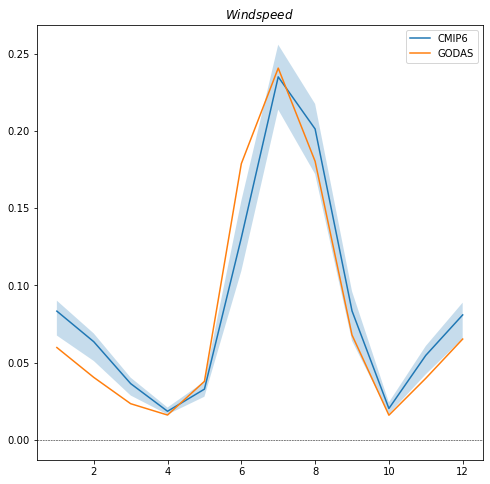

In [13]:
a = plot_region_MM(WSPM, WSCM, 10, 20, 50, 70)#arab sea

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


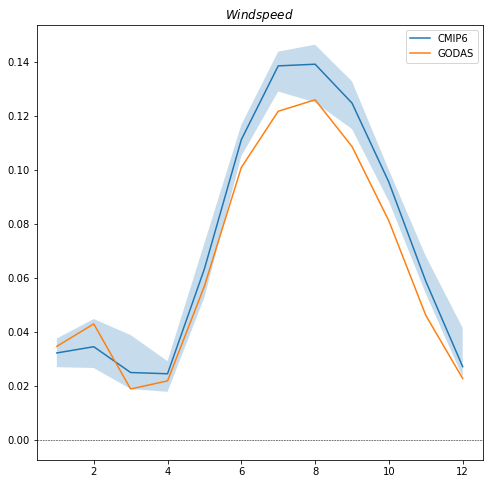

In [36]:
a = plot_region_MM(WSPM, WSCM, -10, -7, 50, 70)#SCTR

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


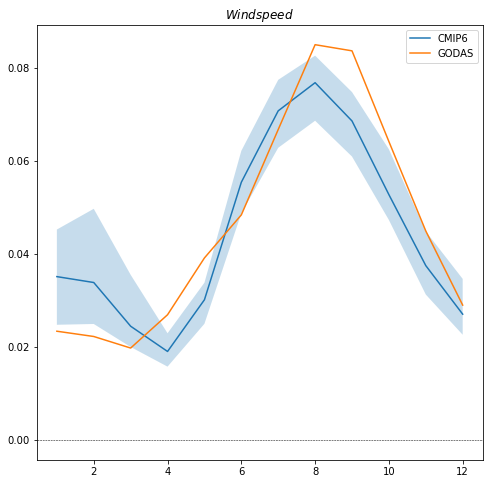

In [37]:
a = plot_region_MM(WSPM, WSCM, -10, 0, 90, 110)#SETIO

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


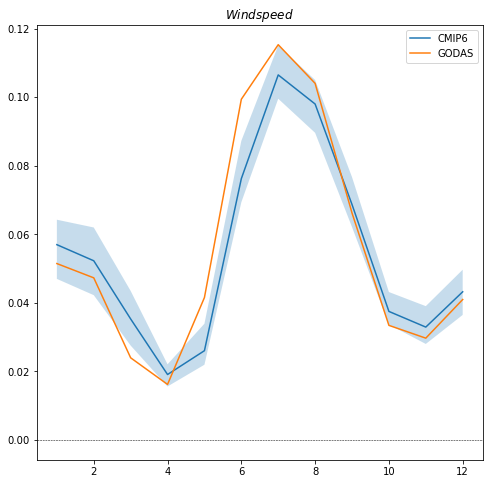

In [38]:
a = plot_region_MM(WSPM, WSCM, -10, 10, 50, 70)#WTIO

In [16]:
#lets look at temperature gradients and currents to see what is wrong and where

In [12]:
OSST = xr.open_mfdataset('/home/z5113258/Documents/data/NOAA_OISSTv2.nc', parallel=True).sst


In [13]:
OSST

<xarray.DataArray 'sst' (time: 483, lat: 180, lon: 360)>
dask.array<open_dataset-365478b4df9308c4e8b7bbfb465edcabsst, shape=(483, 180, 360), dtype=float32, chunksize=(483, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1981-12-01 1982-01-01 ... 2022-02-01
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    standard_name:         sea_surface_temperature
    long_name:             Monthly Mean of Sea Surface Temperature
    units:                 degC
    unpacked_valid_range:  [-5. 40.]
    actual_range:          [-1.7999996 35.56862  ]
    precision:             2
    var_desc:              Sea Surface Temperature
    dataset:               NOAA Optimum Interpolation (OI) SST V2
    level_desc:            Surface
    statistic:             Mean
    parent_stat:           Weekly Mean
    cell_methods:          time: mean (monthly from weekly values interpolate...

In [14]:
OSST = xr.open_mfdataset('/home/z5113258/Documents/data/NOAA_OISSTv2.nc', parallel=True).sst
LSM = xr.open_dataset('/home/z5113258/Documents/data/LSM.nc').mask
OSST= OSST.where(LSM[0])
OSST = OSST = OSST.groupby('time.month').mean('time').sel(lat=slice(-40,30),lon=slice(30,125))


/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


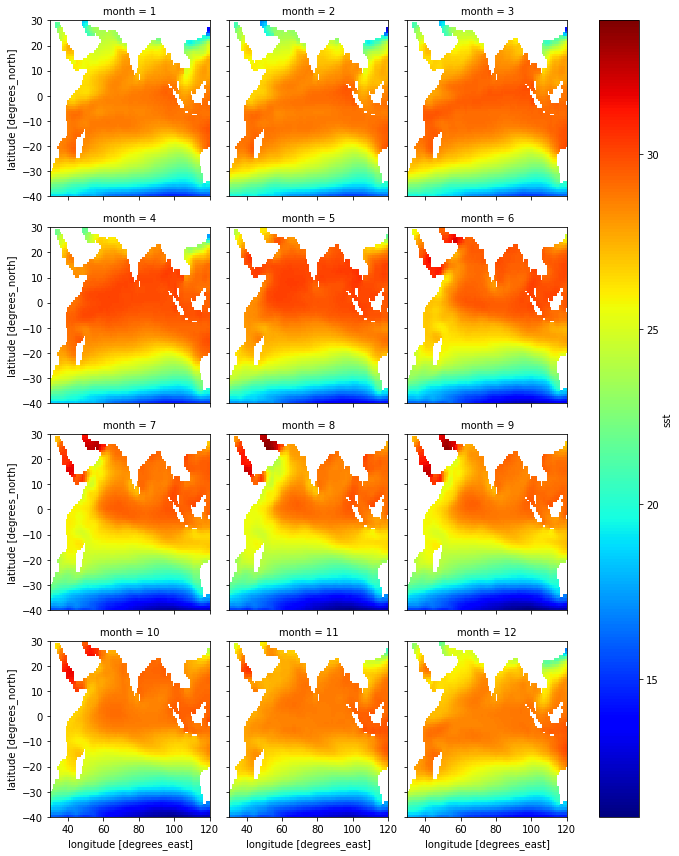

In [11]:
OSST.sel(lat=slice(-40,40),lon=slice(20,120)).plot(col='month', col_wrap = 3, cmap = 'jet')

In [15]:
SSTB = SSTMM- OSST

In [16]:
SSTB2 = SSTM - OSST

In [17]:
#calculate where bias agreeing on sign is significant
SSTB2_pos = xr.where(SSTB2>0, 1,0)
SSTB2_neg = xr.where(SSTB2<0, 1,0)

SSTB_pos_ = SSTB2_pos.sum('model')
pos = xr.where(SSTB_pos_ >= 15, 1, 0)

SSTB_pos_ = SSTB2_neg.sum('model')
neg = xr.where(SSTB_pos_ >= 15, 1, 0)
sigbias = xr.where((pos+neg)==1, 1, np.nan)

In [18]:
import cartopy.crs as ccrs
import matplotlib.patches as patches
from shapely import geometry

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/z5113258/anaconda3/lib/python3.8/site-packages/xarray/plot/facetgrid.py:390: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/

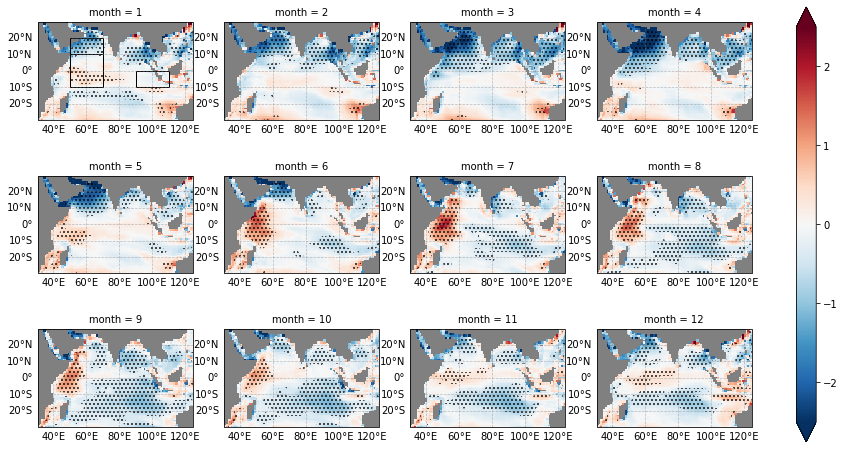

In [19]:
#plt.figure(figsize=(16,16))
monthDict={0:'Jan', 1:'Feb', 2:'Mar', 3:'Apr', 4:'May', 5:'Jun', 6:'Jul', 7:'Aug', 8:'Sep', 9:'Oct', 10:'Nov', 11:'Dec'}
fg = SSTB2.median('model').plot(col='month', col_wrap = 4,  transform=ccrs.PlateCarree(),
                             subplot_kws={"projection": ccrs.PlateCarree()}, 
                              figsize=(16,8), vmin = -2.5, vmax = 2.5, cmap = 'RdBu_r')
for i, ax in enumerate(fg.axes.flat):
    ax.contourf(sigbias.lon, sigbias.lat, sigbias[i], [1,2], colors='none', hatches=['...',None])
    #ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    #ax.title(monthDict[i])
    if i == 0:
        ax.add_patch(patches.Rectangle((50,-10), 20, 20, color="k", fill = False, linewidth=1))
        ax.add_patch(patches.Rectangle((50,10), 20, 10, color="k", fill = False, linewidth=1))
        ax.add_patch(patches.Rectangle((90,-10), 20, 10, color="k", fill = False, linewidth=1))


In [19]:
#now do the same for Z20 depth in models versus SODA3.4.2
OZ20 = xr.open_mfdataset('/home/z5113258/Documents/SODA3.4.2/z20/*.nc', parallel=True).temp


In [20]:
OZ20 = OZ20.groupby('time.month').mean('time').sel(lat=slice(-40,30),lon=slice(30,125))

In [21]:
#laod i model z20

In [22]:
datadir = '/home/z5113258/Documents/data/CMIP6_HB/'
#dict with file names
Z20={}
#get all data for temp tendency
varis = '_z20.nc'
for model in os.listdir(datadir):
    #go thorugh all varis
    if model in ['NESM3']:
        pass
    else:
        inp_files = (os.path.join(datadir, model, str(model+varis)))
        try:
            #load in file
            var = xr.open_dataarray(inp_files)
            if var.mean() > 1000:
                var = var/100
            #put into dict
        except Exception as e:
            print(e)
            pass
        #now append data to model dict
        Z20[model] = var

[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB/GODAS/GODAS_z20.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB/SODA3.4.2/SODA3.4.2_z20.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB/ORAS5/ORAS5_z20.nc'


In [23]:
len(Z20.keys())

23

In [24]:
#make multimodel DA of z20
#Z20 = {key: value for key, value in sorted(Z20.items())}
for i, model in enumerate(Z20.keys()):
    z20 = Z20[model]
    z20 = z20.assign_coords({"model":i})
    if i == 0:
        z20m = z20
    else:
        z20m = xr.concat([z20m, z20], dim = 'model')

In [25]:
z20B = z20m - OZ20
#calculate where bias agreeing on sign is significant
z20b_pos = xr.where(z20B>0, 1,0)
z20b_neg = xr.where(z20B<0, 1,0)

z20b_pos_ = z20b_pos.sum('model')
pos = xr.where(z20b_pos_ >= 15, 1, 0)

z20b_neg_ = z20b_neg.sum('model')
neg = xr.where(z20b_neg_ >= 15, 1, 0)
sigbias_z20 = xr.where((pos+neg)==1, 1, np.nan)

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/xarray/plot/facetgrid.py:390: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: Run

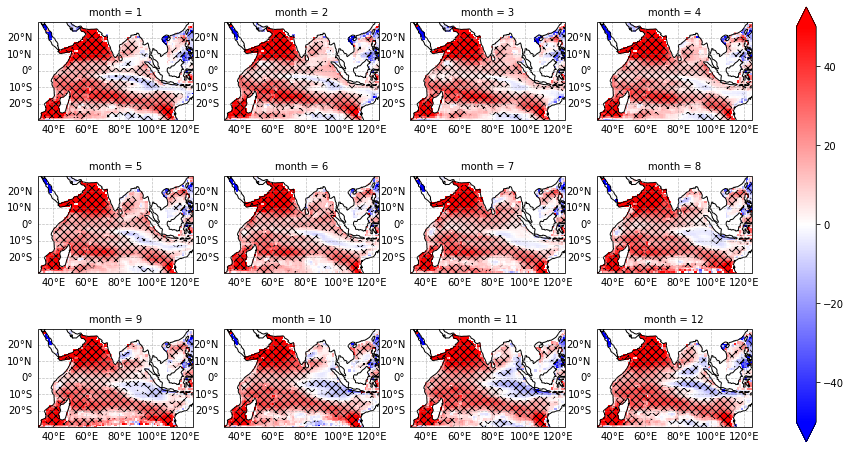

In [33]:
#now get spatial plot
fg = z20B.mean('model').plot(col='month', col_wrap = 4,  transform=ccrs.PlateCarree(),
                             subplot_kws={"projection": ccrs.PlateCarree()}, 
                              figsize=(16,8), vmin = -50, cmap = 'bwr')
for i, ax in enumerate(fg.axes.flat):
    ax.contourf(sigbias_z20.lon, sigbias_z20.lat, sigbias_z20[i], [1,2], colors='none', hatches=['xxx',None])
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False


/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


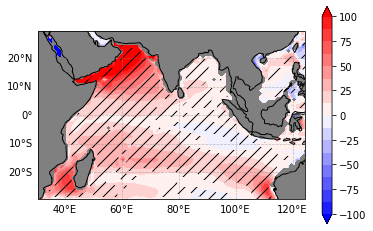

In [89]:
fig = z20B.mean('model').mean('month').plot.contourf(
     subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor="gray"),
     transform=ccrs.PlateCarree(), vmin = -100, levels = 17, cmap = 'bwr')
ax = fig.axes
ax.contourf(sigbias_z20.lon, sigbias_z20.lat, sigbias_z20[i], [1,2], colors='none', hatches=['//',None])
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

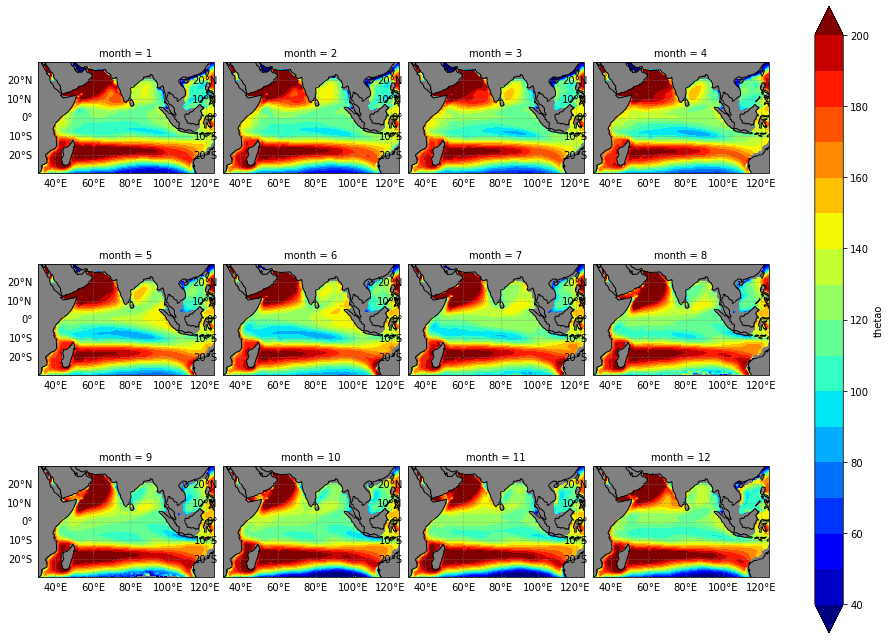

In [114]:
fig = z20m.mean('model').plot.contourf(col = 'month', col_wrap = 4,
     subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor="gray"),
     transform=ccrs.PlateCarree(), vmin = 40, vmax = 200, levels = 17, cmap = 'jet')
for i, ax in enumerate(fig.axes.flat):
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.

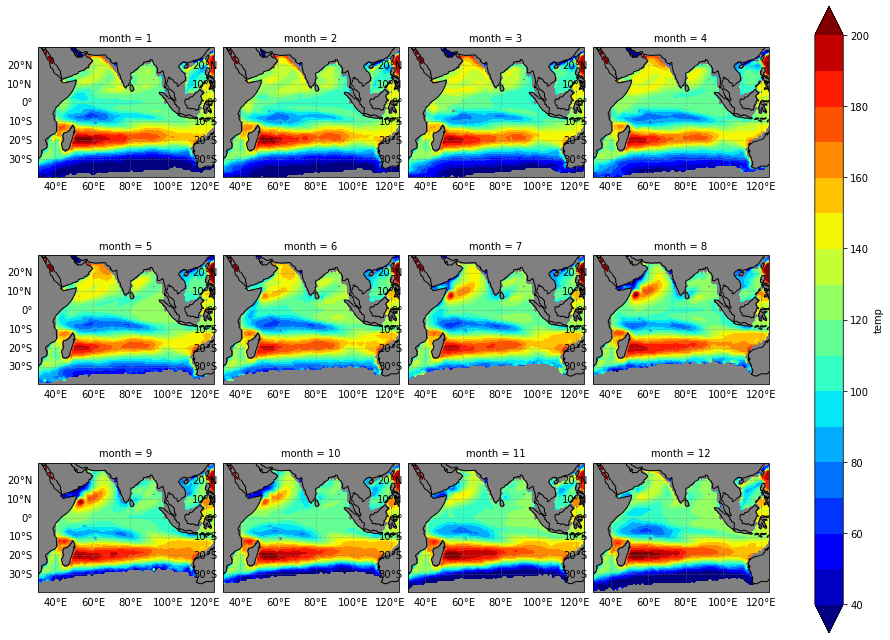

In [113]:
fig = OZ20.plot.contourf(col = 'month', col_wrap = 4,
     subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor="gray"),
     transform=ccrs.PlateCarree(), vmin = 40, vmax = 200, levels = 17, cmap = 'jet')
for i, ax in enumerate(fig.axes.flat):
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

In [27]:
WSB = WSPM - Ows

In [28]:
#calculate where bias agreeing on sign is significant
Wb_pos = xr.where(WSB>0, 1,0)
Wb_neg = xr.where(WSB<0, 1,0)

Wb_pos_ = Wb_pos.sum('model')
posW = xr.where(Wb_pos_ >= 15, 1, 0)

Wb_neg_ = Wb_neg.sum('model')
negW = xr.where(Wb_neg_ >= 15, 1, 0)
sigbias_W = xr.where((posW+negW)==1, 1, np.nan)

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/xarray/plot/facetgrid.py:390: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: Run

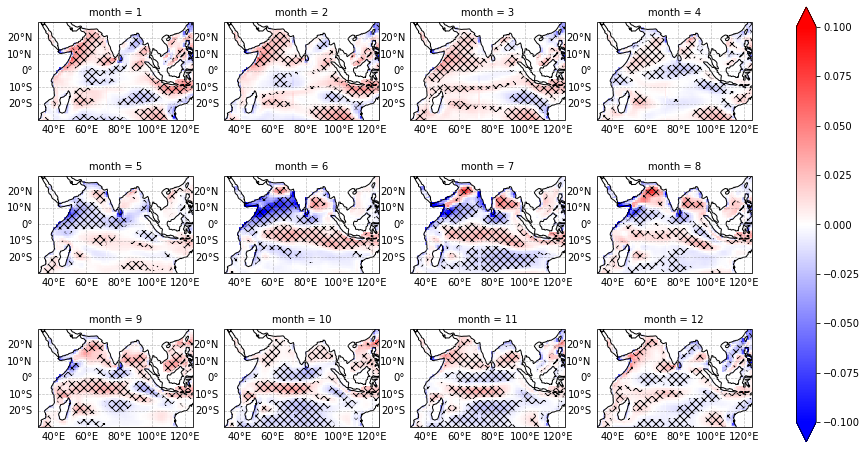

In [29]:
#WSB.median('model').sel(lat=slice(-40,30),lon=slice(30,125)).plot(col = 'month', col_wrap = 4)
fg = WSB.mean('model').sel(lat=slice(-40,30),lon=slice(30,125)).plot(col='month', col_wrap = 4,  transform=ccrs.PlateCarree(),
                             subplot_kws={"projection": ccrs.PlateCarree()}, 
                              figsize=(16,8), vmin = -0.1, cmap = 'bwr')
for i, ax in enumerate(fg.axes.flat):
    ax.contourf(sigbias_W.sel(lat=slice(-40,30),lon=slice(30,125)).lon, sigbias_W.sel(lat=slice(-40,30),lon=slice(30,125)).lat,
                sigbias_W.sel(lat=slice(-40,30),lon=slice(30,125))[i], [1,2], colors='none', hatches=['xxx',None])
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False


In [63]:
import xskillscore as xs

In [106]:
test = xs.pearson_r(SSTB2, z20B, dim = 'model')

In [99]:
z20B.model

<xarray.DataArray 'model' (model: 19)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18])
Coordinates:
  * model    (model) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18

In [105]:
SSTB2 = SSTB2.assign_coords({'model': z20B.model})

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


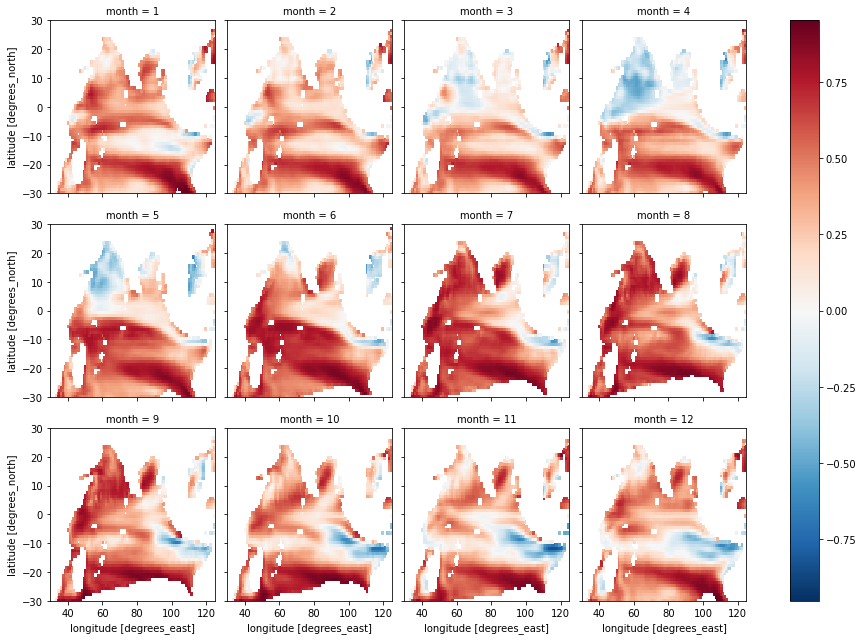

In [108]:
test.plot(col = 'month', col_wrap = 4)